# Toxicity in Online Gaming Communities
#### Taichi Akiyama (taichia) and Sharika Hegde (sjhegde)

The amount of data and user metrics stored in video game databases (particularly DoTA 2) is immense, and as users we can run a lot of computation on these informations to gain insight on players and how they interact with other. Most online gaming communities suffer from "toxic" communities. Toxicity in gamming communities is a broad topic. According to http://pcgamer.com, toxicity includes "ragingover sub-optimal team compositions or under-performing teammates to slinging insults steeped in racism, sexism, and homophobia. [Toxicity] is a problem that has plagued gaming pretty much as long as we've been connecting our computers to play with and against each other online." Toxicity in gaming is so severe that many companies, including Blizzard, Riot, Twitch, and Discord have joined together to form the Fair Play Alliance (http://www.fairplayalliance.org/) to tackle and prevent player toxicity.

Our original project involved detecting the toxicity of players and the effect of toxicity on win rates. We realized, however, that the raw data we were using was very poor in quality and was not easy to process. When playing video games, people do not usually use English words or complete sentences when communicating with teammates. Instead they use game jargon such as "noob" and "bkb" to communicate. Another problem we encountered was that a large part of the player base were non-english speakers. Because of this, we have scaled down our project to simply focus heavily on two NLP cleaning techniques and also some basic analysis using these techniques.


### Project content
- [Gathering Data](#scrape)
- [Spell Check](#spelling)
- [Normalization](#norm)
- [Wikipedia Training and Testing Data](#train)
- [Tf-idf Feature Extraction](#tf-idf)
- [SVM Training and Validation](#svm_train) 
- [Naive Bayes Training](#bayes_train)
- [Cleaning and Normalizing the DOTA data (threading)](#threading)
- [Predictions (SVM and Naive Bayes)](#prediction)
- [Visuals](#visuals)
- [Conclusions](#conclusions)
- [Resources](#resources)


<a id='scrape'></a>
For the beginning of the project, we need to collect data using 2 seperate APIs (everything can be done with 1 api, but OpenDota limits our requests to 50,000 a month, so we will only use that particular api when necessary). First, we setup our account to generate an API key on valve's server.

To do this, head to https://steamcommunity.com/login/home/?goto=%2Fdev%2Fapikey, login to your steam account, and generate an api key. Then, store that key in a key.txt file.

## Gathering Data

In [287]:
import requests
import json
import time
import copy
import nltk
from nltk.corpus import gutenberg, stopwords
import re
from collections import Counter
import json
import pandas as pd
import spacy
import sklearn
import numpy as np
from sklearn.naive_bayes import BernoulliNB
import threading
import random
import numpy
from matplotlib import pyplot


with open("key.txt", 'r') as f:
    key = f.read()

After generating the API key, we need to gather match IDs to grab player IDs, which we will use to grab the word cloud of each specific player. A word cloud is a dictionary of words where the keys are all words typed by that specific player and how many times it has been used. This function will give us metadata for the recent 500 matches that have been played on valve servers.

After generating the API key, we need to gather match IDs to grab player IDs, which we will use to grab the word cloud of each specific player. A word cloud is a dictionary of words where the keys are all words typed by that specific player and how many times it has been used. This function will give us metadata for the recent 500 matches that have been played on valve servers.

In [2]:
#This will only get us recent 500 matches
def retrieve_recent_match_data(key, start_at=None):
    if start_at is None:
        r = requests.get("https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?key=" + key + "&min_players=10")
        if r.status_code != 200:
            raise Exception("Servers might be down")
        else:
            return json.loads(r.text)
    else:
        r = requests.get("https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?start_at_match_id=" 
                         + str(start_at) + "&key=" + key + "&min_players=10")
        if r.status_code != 200:
            raise Exception("Either match id was bad or servers might be down")
        else:
            return json.loads(r.text)

We know that players who choose not to share their data publicly have an account id of 4294967295, so we ignore those.

In [3]:
private_id = 4294967295 #players that we can not get info from
unique_id = set([])
least_recent = None
leave_loop = False
while leave_loop is False:
    matches = retrieve_recent_match_data(key, start_at = least_recent)
    if matches['result']['results_remaining'] == 0:
        leave_loop = True
    for m in matches['result']['matches']:
        least_recent = m['match_id']
        for p in m['players']:
            if 'account_id' in p and p['account_id'] != private_id:
                unique_id.add(p['account_id'])
    time.sleep(0.9)
    print(len(unique_id))

271
535
811
1088
1370
1387


In a real world enviroment, we would need more than 1000 unique player ID's, so we will branch off and search for recent games played by the initial scrape and find other unique players.

In [22]:
def find_player_recent_match(key, player_id, start_at = None):
    if start_at is None:
        r = requests.get("https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?key=" + key + 
                         "&min_players=10&account_id="+str(player_id))
        if r.status_code != 200:
            raise Exception("Servers might be down")
        else:
            return json.loads(r.text)
    else:
        r = requests.get("https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?start_at_match_id=" 
                         + str(start_at) + "&key=" + key + "&min_players=10&account_id="+str(player_id))
        if r.status_code != 200:
            raise Exception("Either match id was bad or servers might be down")
        else:
            return json.loads(r.text)

In [6]:
temp_set = copy.deepcopy(unique_id)
for account_id in temp_set:
    leave_loop = False
    least_recent = None
    while leave_loop is False:
        matches = find_player_recent_match(key, account_id, start_at = least_recent)
        if matches['result']['results_remaining'] == 0:
            leave_loop = True
        for m in matches['result']['matches']:
            least_recent = m['match_id']
            for p in m['players']:
                if 'account_id' in p and p['account_id'] != private_id:
                    unique_id.add(p['account_id'])
        time.sleep(0.9)
        print(len(unique_id))
    if len(unique_id) > 50000:
        break

1776
2158
2555
2946
3302
3313
3485
3800
4047
4176
4524
4908
5247
5713
6208
6231
6402
6538
6715
6830
7011
7019
7243
7555
7932
7986
8160
8310
8495
8698
9037
9054
9400
9776
10186
10569
10904
10919
11060
11197
11325
11492
11632
11637
12022
12410
12772
13143
13532
13549
13686
13822
14015
14271
14490
14505
14867
15227
15628
15973
16335
16353
16644
16877
17209
17544
17886
18191
18439
18470
18783
19142
19528
19985
20436
20460
21043
21488
21871
22240
22638
22652
22655
22869
23112
23329
23547
23792
23804
24020
24171
24332
24541
24791
24802
24966
25123
25304
25488
25701
25708
26236
26840
27463
27992
28563
28588
29268
29893
30521
31129
31749
31766
32288
32863
33378
33882
34349
34370
34557
34724
34884
35027
35223
35230
35804
36371
36929
37494
38020
38041
38402
38730
39097
39540
40050
40076
40537
40935
41344
41789
42204
42219
42268
42591
42925
43260
43553
43869
43883
44128
44332
44569
44811
45040
45047
45611
46162
46702
47245
47805
47826
48101
48353
48612
48866
49187
49202
49699
50168
50664
51201
51

We now save this list of player ID's before we move on. You can easily reload the data now with a simple with open() statement.

In [5]:
# with open("player_id.txt", 'w') as f:
#     for p in unique_id:
#         f.write(str(p))
#         f.write("\n")
unique_id = []
with open("player_id.txt", 'r') as f:
    for line in f:
        unique_id.append(int(line))
    
print(unique_id[0:10])

[287834122, 392167434, 18874380, 376700941, 116654092, 230686737, 295567377, 85065746, 180092949, 142737431]


In [10]:
#Nested dictionary, key1 = player_id, key2 = my_word_counts (things players has said), key3 = all_word_counts (things
#players have heard)
user_word_cloud = {}
win_loss = {}
def get_word_cloud(player_id):
    r = requests.get("https://api.opendota.com/api/players/" + str(player_id) +"/wordcloud")
    if r.status_code == 500:
        raise Exception("servers are down")
    if r.status_code != 200:
        return r.status_code
    else:
        return json.loads(r.text)

def get_win_rate(player_id):
    r = requests.get("https://api.opendota.com/api/players/" + str(player_id)+ "/wl")
    if r.status_code == 500:
        raise Exception("servers are down")
    if r.status_code != 200:
        return r.status_code
    else:
        return json.loads(r.text)    
    
all_ids = list(unique_id)
counter = 0
for i in range(500):
    words = get_word_cloud(all_ids[i])
    if type(words) is int:
        print(str(all_ids[i]) + " caused a " + str(words) + " response")
        counter += 1
        continue
    elif len(words["my_word_counts"]) == 0:
        continue
    user_word_cloud[all_ids[i]] = words['my_word_counts']
    time.sleep(2)
    win_rate = get_win_rate(all_ids[i])
    if type(win_rate) is int:
        print(str(all_ids[i]) + " caused a " + str(words) + " response")
        counter += 1
        continue
    win_loss[all_ids[i]] = win_rate
    time.sleep(2)

KeyboardInterrupt: 

In [12]:
with open("complete_word_cloud.json", 'w') as f:
    json.dump(user_word_cloud, f)
with open("win_loss.json", 'w') as f:
    json.dump(win_loss, f)

In [11]:
print(len(user_word_cloud))
print(len(win_loss))
print(counter) ##check to see how many failures we got

169
168
0


## Cleaning
Now that we have gathered all of the raw data we will begin the cleaning process. First we begin by creating a list of words that are commonly used in the game but are not part of the English language. Many of these words were found at https://dota2.gamepedia.com/Glossary.

In [56]:
#Add special game words into list: https://dota2.gamepedia.com/Glossary

game_words = []
game_words.append("AA")
game_words.append("AC")
game_words.append("Aggro")
game_words.append("AM")
game_words.append("AoE")
game_words.append("AW")
game_words.append("bb")
game_words.append("bd")
game_words.append("bf")
game_words.append("bh")
game_words.append("bkb")
game_words.append("bm")
game_words.append("brb")
game_words.append("bs")
game_words.append("CC")
game_words.append("cc")
game_words.append("cd")
game_words.append("ck")
game_words.append("cm")
game_words.append("dd")
game_words.append("cs")
game_words.append("deward")
game_words.append("dgu")
game_words.append("dk")
game_words.append("dp")
game_words.append("DoT")
game_words.append("epi")
game_words.append("ES")
game_words.append("ET")
game_words.append("EXP")
game_words.append("XP")
game_words.append("EZ")
game_words.append("FB")
game_words.append("FF")
game_words.append("FoW")
game_words.append("Furion")
game_words.append("Gank")
game_words.append("gg")
game_words.append("ggwp")
game_words.append("gj")
game_words.append("glhf")
game_words.append("Guinsoo")
game_words.append("HH")
game_words.append("HP")
game_words.append("inc")
game_words.append("Janggo")
game_words.append("KotL")
game_words.append("KS")
game_words.append("LC")
game_words.append("Leoric")
game_words.append("Lothar")
game_words.append("LS")
game_words.append("LSA")
game_words.append("mic")
game_words.append("mls")
game_words.append("MIA")
game_words.append("MK")
game_words.append("MKB")
game_words.append("MP")
game_words.append("MS")
game_words.append("N'aix")
game_words.append("Nerub")
game_words.append("nj")
game_words.append("OC")
game_words.append("OD")
game_words.append("offlane")
game_words.append("offlaner")
game_words.append("omni")
game_words.append("oom")
game_words.append("PA")
game_words.append("PL")
game_words.append("PP")
game_words.append("PotM")
game_words.append("proc")
game_words.append("QoP")
game_words.append("rax")
game_words.append("recrow")
game_words.append("RNG")
game_words.append("Ro3")
game_words.append("rosh")
game_words.append("rs")
game_words.append("RP")
game_words.append("SB")
game_words.append("SF")
game_words.append("sheepstick")
game_words.append("SK")
game_words.append("SnY")
game_words.append("SS")
game_words.append("TA")
game_words.append("TB")
game_words.append("TP")
game_words.append("UAM")
game_words.append("Ult")
game_words.append("Ulti")
game_words.append("VS")
game_words.append("WD")
game_words.append("wp")
game_words.append("WR")
game_words.append("WW")

After scraping all of this data and saving it, we begin our analysis:

In [303]:
with open("complete_word_cloud.json", 'r') as f:
    complete_word_cloud = json.load(f)
ids = []
with open("player_id.txt", 'r') as f:
    for line in f.readlines():
        ids.append(line)

with open("win_loss.json", 'r') as w:
    win_loss = json.load(w)

Most of the words used in dota are slang, abbreviations, profanity, or are completely misspelled. We started cleaning the data by using a spell check on all the words first. The spell check works as follows.

<a id='spelling'></a>
## Spell Check 
### Probability Theory
The function `spell_check` tries to look for the most likely spelling correction for the word. Meaning, the function tries to maximize the probability that the output is the correct spelling correction given the original word. More details on the math behind this spelling corrector can be found here: http://norvig.com/spell-correct.html The four parts of this expression are:

##### Candidate Model: c ∈ candidates
This all the words that are one (or more) corrections away from the word. These are the possible corrections we should consider.
##### Language Model: P(c) 
The probability that c appears in text. For this example we use Wikipedia comments which tend to have lots of slang as well, so for example if the word "rip" shows up in .01% of the input corpus then we'd expect to see P('rip') = .0001.
##### Error Model: P(a|c)
This characterizes the probability that a is typed when the author means c. The example from norvig.com is that 
P(teh|the) is relatively high, but P(theeexyz|the) would be very low.
##### Selection Mechanism: argmax 
We should choose the one with the highest error and language model probability.

### The Corpus
The corpus we are using, `train.csv`, has a large number of Wikipedia comments. This file will be discussed more in the following.

In [366]:
def words(text): return re.findall(r'\w+', text.lower())

with open('train_1000.csv', 'r') as f:
    #SPELL CHECK ONLY RUNS ON DOTA DATA
    text = f.read()
    wiki_words = Counter(text.split())

N=sum(wiki_words.values())

def P(word):
    #language model
    return wiki_words[word] / N

def spell_check(word):
    #selection model
    words = list(alt_spellings(word))
    P_words = [P(i) for i in words]
    index = P_words.index(max(P_words))
    return words[index]

def alt_spellings(word):
    #candidate model
    if known([word]) != set(): return known([word])
    elif known(r1_edits(word)) != set(): return known(r1_edits(word))
    elif known(r2_edits(word)) != set(): return known(r2_edits(word))
    return [word]

def known(words):
    #error model
    return set(w for w in words if w in wiki_words)

def r1_edits(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [word[:i] + word[i+1:]   for i in range(len(word))]
    switch     = [word[:i] + word[i+1] + word[i] + word[i+2:]   for i in range(len(word) - 1)]
    replace    = [word[:i] + c + word[i+1:]  for i in range(len(word)) for c in letters]
    insert     = [(word[:i] + c + word[i:])    for i in range(len(word) + 1) for c in letters]

    return set(deletes + switch + replace + insert)

def r2_edits(word):
    return (e2 for e1 in r1_edits(word) for e2 in r1_edits(e1))

print(spell_check('stuuupid'))
print(spell_check('toxcit'))

stupid
toxcit


<a id='norm'></a>
## Normalizing
There are many techniques to normalization, the two most common forms include lemmatization and stemming. Here we use lemmatization. Lemmatization gets the basic word form, or lemma, by replacing the suffix of a word with a different one or completely removing the suffix altogether.

In [367]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")

def normalize(comment):
    comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma != '-PRON-': lemmatized.append(lemma)
    return " ".join(lemmatized)

<a id='train'></a>
## Wikipedia Training and Testing Data
Now that we have a functioning spell-check, we can begin working with data and training our model. Let's take a look at this pre-labeled data set. This data set was used in a contest on toxcitiy in wikipedia comments.

In [368]:
train = pd.read_csv('train_1000.csv')
train.head(n=7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


Now we will create a column for overall player toxicity. This column is named "clean" which is True if the commenter's words are clean non-toxic. We then sperate the data into our x-values, the comments, and y-values, the binary variable for toxicity. 

In [369]:
#Let's separate the data itself and the target class labels into separate variables.
train.index = train['id']
x_train = train['comment_text']
y = train.iloc[:, 2:]

y['clean']= 1 - y.sum(axis=1) >= 1  #adding a column for if the data is clean
y_train = y['clean']
y.head(n=7)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
id,,,,,,,
0000997932d777bf,0,0,0,0,0,0,True
000103f0d9cfb60f,0,0,0,0,0,0,True
000113f07ec002fd,0,0,0,0,0,0,True
0001b41b1c6bb37e,0,0,0,0,0,0,True
0001d958c54c6e35,0,0,0,0,0,0,True
00025465d4725e87,0,0,0,0,0,0,True
0002bcb3da6cb337,1,1,1,0,1,0,False


#### Training Data

In [370]:
x_train.head(n=7)

id
0000997932d777bf    Explanation\nWhy the edits made under my usern...
000103f0d9cfb60f    D'aww! He matches this background colour I'm s...
000113f07ec002fd    Hey man, I'm really not trying to edit war. It...
0001b41b1c6bb37e    "\nMore\nI can't make any real suggestions on ...
0001d958c54c6e35    You, sir, are my hero. Any chance you remember...
00025465d4725e87    "\n\nCongratulations from me as well, use the ...
0002bcb3da6cb337         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Name: comment_text, dtype: object

In [371]:
y_train.head(n=7)

id
0000997932d777bf     True
000103f0d9cfb60f     True
000113f07ec002fd     True
0001b41b1c6bb37e     True
0001d958c54c6e35     True
00025465d4725e87     True
0002bcb3da6cb337    False
Name: clean, dtype: bool

#### Testing Data

In [372]:
test = pd.read_csv('train_2000.csv')
test.index = test['id']

x_test = test['comment_text']
y_test = test.iloc[:, 2:]

y_test = 1 - y_test.sum(axis=1) >= 1  #adding a column for if the data is clean

In [373]:
x_test.to_frame().head(n=7)

,comment_text
id,
00a9d33dea92c45c,We descendants of Otman Baba trough Mehmed Ali...
00ab1b314832a2d9,Could you clarify? Do you want me to start an...
00ab65775c601cf9,Atheism is full of bias shit
00aba7c4e1446fd5,"""\n\n You beat me to it. \n\nJust wanted to sa..."
00ac1b5af6c85483,You removed the link to the same references us...
00aca5068fb3fd6c,Thanks for that. I'll take a deep breath and h...
00ad06b94e4aafd2,"German Article of the day\n\nDear Jimbo, Germa..."


In [374]:
y_test.to_frame().head(n=7)

,0
id,
00a9d33dea92c45c,True
00ab1b314832a2d9,True
00ab65775c601cf9,False
00aba7c4e1446fd5,True
00ac1b5af6c85483,True
00aca5068fb3fd6c,True
00ad06b94e4aafd2,True


### Cleaning the Training and Testing Data

In [375]:
x_train_clean = x_train.apply(normalize)
#x_train_clean.to_frame().head(n=7)
x_test_clean = x_test.apply(normalize)

<a id='tf-idf'></a>
### TF_IDF - Creating Features

In [376]:
def create_features(x):
    words = []
    for row in x:
        words.append((str(row)))
    tf_idf = sklearn.feature_extraction.text.TfidfVectorizer()
    return (tf_idf, tf_idf.fit_transform(words))

(tfidf, X) = create_features(x_train_clean)

<a id='svm_train'></a>
### SVM_Training

In [377]:
def learn_SVM_classifier(X_train, y_train, kernel='linear'):
    return sklearn.svm.classes.SVC(kernel=kernel).fit(X_train, np.array(y_train))

svm_classifier = learn_SVM_classifier(X, y_train)

#### Validating SVM Training

In [378]:
words = []
for row in x_test_clean:
    words.append((str(row)))
X_trans = tfidf.transform(words)

svm_classifier.score(X_trans, y_test)

0.9176829268292683

This is quite a high accurary.

<a id='bayes_train'></a>
### Naive Bayes Training

In [379]:
def learnbayes_classifier(X_train, y_train):
    clf = BernoulliNB()
    return clf.fit(X_train, y_train)

bayes_classifier = learnbayes_classifier(X, y_train)

<a id='threading'></a>
### Cleaning and Normalizing the DOTA data - Threading

Because the cleaning and normalizing functin takes a while, we implemented threading to get this done slightly faster.

In [ ]:
player_x = {}

class PlayerThread(threading.Thread):
    def __init__(self, player):
        threading.Thread.__init__(self)
        self.player = player
    def run(self):
        player_text = " "
        for key in complete_word_cloud[self.player]:
            if key not in game_words:
                key = spell_check(key)
            player_text = player_text + key + " "
        player_x[self.player] = player_text
        print('finished player ' + str(self.player))

threads = [PlayerThread(player) for player in complete_word_cloud]

# Start new Threads
for t in threads: t.start()

# Wait for all threads to complete
for t in threads:
    t.join()

with open("player_x.json", 'w') as f:
    json.dump(player_x, f)

finished player 376700941
finished player 180092949finished player 137887779

finished player 289931316
finished player 158072895finished player 293863497

finished player 104857684
finished player 233046129
finished player 137101401
finished player 425721991
finished player 153747520
finished player 412352666finished player 171835567
finished player 148897973

finished player 141689025finished player 844628158finished player 224133306finished player 140902535



finished player 126877905finished player 321519808

finished player 415498488finished player 294387944finished player 416284931finished player 11796746


finished player 131465485finished player 70778979


finished player 209584217
finished player 239862023finished player 326369597finished player 146145597finished player 298975491finished player 255983935finished player 218104135finished player 312737963






finished player 142737431finished player 58458492finished player 135397758


finished player 92799367finished player 1

In [382]:
for player in player_x:
    text = player_x[player]
    player_x[player] = normalize(text)

X_player = [player_x[p] for p in player_x]

<a id='prediction'></a>
### SVM Prediction

In [383]:
#is the player non-toxic?
def SVMclassify_players(tfidf, svm_classifier, words):
    X = tfidf.transform(words)
    return svm_classifier.predict(X)

SVM_y_pred = SVMclassify_players(tfidf, svm_classifier, X_player)
print(SVM_y_pred)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True False  True False]


### Naive Bayes Prediction

In [388]:
#is the player non-toxic?
def BAYESclassify_players(tfidf, bayes_classifier, words):
    X = tfidf.transform(words)
    return bayes_classifier.predict(X)

bayes_y_pred = BAYESclassify_players(tfidf, bayes_classifier, X_player)
print(len(bayes_y_pred))
print(bayes_y_pred)

44
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True False  True False
  True False False False False False False  True]


<a id='visuals'></a>
### Word Cloud

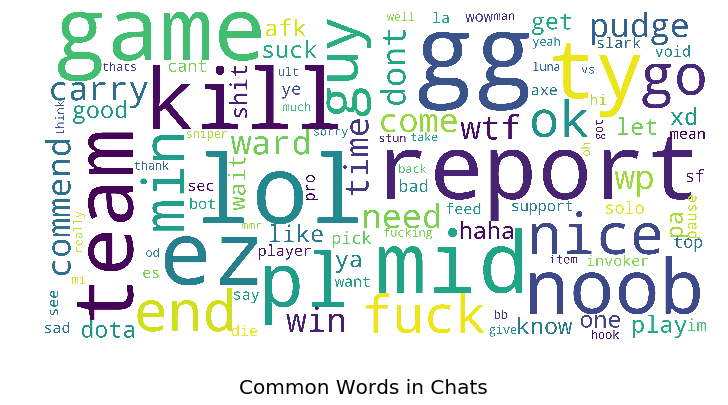

In [389]:
stopwords = stops

text = ""
for player in complete_word_cloud:
    for word in complete_word_cloud[player]:
        frequency = (complete_word_cloud[player])[word]
        text = text + (word.strip() + " ")

def show_wordcloud(data, title = 'Common Words in Chats'):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=60,
        scale=10,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(text)


### HISTOGRAMS

In [391]:
win_rates = []
for player in win_loss:
    win_rate =(win_loss[player])['win'] / ((win_loss[player])['win'] + (win_loss[player])['lose'])
    win_rates.append(win_rate)
print(len(win_rates))

svm_toxic, svm_nontoxic, bayes_toxic, bayes_nontoxic = [], [], [], []

for i in range(len(win_rates)):
    if SVM_y_pred[i]: svm_nontoxic.append(win_rates[i])
    else: svm_toxic.append(win_rates[i])

for i in range(len(win_rates)):
    if bayes_y_pred[i]: bayes_nontoxic.append(win_rates[i])
    else: bayes_toxic.append(win_rates[i])



data = [svm_toxic, svm_nontoxic]

fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(["toxic", "nontoxic"])
ax.set_title('Player Win Rates - (SVM Toxicity)')

plt.show()

data = [bayes_toxic, bayes_nontoxic]

fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(["toxic", "nontoxic"])
ax.set_title('Player Win Rates - (Naive Bayes Toxicity)')

plt.show()



168


IndexError: index 44 is out of bounds for axis 0 with size 44

<a id='conclusions'></a>

## Conclusions
Overall it seems that the preliminary analysis of the DoTA data does not show a correlation between player toxicity and win rates. However, it seems that both models classified a larger number of players as not toxic. It is possible that the data set scraped from the opendota api did not include many toxic players. However, it is most likely that the Wikipedia data used for training was not similar to the language used in DoTA. In order to better quantify and predict player toxicty large data sets curated specifically from game play and hand labeled are necessary. Additionally it would be smart to use data from a variety of different games to see what causes and creates toxic environments.

<a id='resources'></a>

## Resources